In [3]:
import torch
import torch.nn as nn
import numpy as np
from torch import tensor, sin, pi
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import random_split, TensorDataset
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## PINNs for solving PDEs

Physics Informed Neural Networks (PINNS) are neural networks that incorporate physics, often described by a PDE, into the training process. This allows the network to be more robust and generalizable by not only learning from the data but also adhering to the underlying physics describing the data. Here, the approach begins with a 1D example problem and is then generalized to solve eigenvalue problems in higher dimensions.

The idea here is to use neural networks to approximate the solution $u$ to this PDE, leveraging their well-known ability as universal function approximators and also automatic differentiation to differentiate the output with respect to their input coordinates.

## 1D problem

Consider the following reaction-diffusion equation in 1D
$$
\begin{align*}
    -\Delta u + u &= (m^2\pi^2+1)\sin(m\pi x),\hspace{10pt}\text{ in }(0,1)\\
    u(0)&=u(1)=0
\end{align*}
$$

This PDE can be solved analytically and the exact solution is given by $u(x) = \sin(m\pi x)$.

In [ ]:
# RHS
def f(x,m=1):
    return (m**2*pi**2+1)*sin(m*pi*x)

# Exact Solution
def u_exact(x,m=1):
    return sin(m*pi*x)

### Creating neural network

In [ ]:
# building PINN neural network using nn.Module class
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 512),           # here 1 describes that we are working in 1D
            nn.Tanh(),
            nn.Linear(512, 256),
            nn.Tanh(),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
# incorporating automatic differentiation
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs),create_graph=True)[0]

### Loss function

The key idea of PINNs is to incorporate the PDE directly into the loss function along with the boundary conditions. This can be thought of as penalizing the network prediction wherever it deviates from the governing PDE and boundary conditions. The gradients arising in the PDE can be easily computed using automatic differentiation.

The parameters of the neural networks can be learned by minimizing the mean-squared error loss function
$$
\begin{align*}
    MSE = MSE_u + MSE_f
\end{align*}
$$
where
$$
\begin{align*}
    MSE_b = |u(0)|^2 + |u(1)|^2
\end{align*}
$$
and
$$
\begin{align*}
    MSE_i = \frac{1}{N_i}\sum_{k=1}^{N_i} |-\Delta u(x_k) +u(x_k) - f(x_k)|^2
\end{align*}
$$
$N_i$ describes the number of collocation points which act as checkpoints to check whether the network prediction $u$ satisfies the PDE. $MSE_i$ describes the interior loss of network prediction, and $MSE_b$ describes the boundary loss. The collocation points, along with the endpoints, serve as training data for PINNs.

In [ ]:
def compute_loss(model: nn.Module, x_train: torch.Tensor,m=1):
    # evaluating u(x), f(x), du/dx, d^2u/dx^2 at training data points
    x_train.requires_grad_(True)
    u = model(x_train)
    du = grad(u,x_train)
    d2u = grad(du,x_train)

    #ODE residual: -u"(x)+ u(x) - f(x)
    residual = -d2u[1:-1] + u[1:-1] - f(x_train[1:-1],m)     # ODE-based interior residual
    interior_loss = torch.mean(residual ** 2)                # mean-squared interior loss

    #calculating boundary loss for problem
    left_residual = u[0]
    right_residual = u[-1]
    boundary_loss = (left_residual ** 2 + right_residual ** 2)/2    # mean-squared boundary loss
    return interior_loss + boundary_loss

Note that as $m$ increases, the exact solution becomes more oscillatory, making it more difficult to approximate using PINNs.

### Generating Training and test dataset

The training set consists of uniformly spaced points in the interval, totaling $n_{train} = N_i+2$ points, where $N_i$ is the number of datapoints in the interior. Initially, the case where $m=1$ is studied, and then $m$ is incrementally increased to assess the performance of PINNs.

In [ ]:
# generate the training set
n_train = 20
x_train = torch.linspace(0,1,n_train).reshape(-1,1).to(device)
x_train.shape

torch.Size([20, 1])

In [ ]:
# generate the test set
n_test = 100
x_test = torch.linspace(0,1,n_test).reshape(-1,1).to(device)
x_test.shape

torch.Size([100, 1])

In [ ]:
# exact solution
u_true = u_exact(x_test)
u_true.shape

torch.Size([100, 1])

### Training and predicting using PINN

Here, LBFGS optimizer with learning rate 0.001 is used to minimize the loss function described above. 6% of the train set is used for validating the output of training process.

In [ ]:
# defining a function to train PINN
def train_PINN(x_train,num_epochs,m=1,verbose = True):
    model = PINN().to(device)
    optimizer = torch.optim.LBFGS(model.parameters(), lr=0.0001)

    # defining the closure function
    def closure():
        optimizer.zero_grad()
        loss = compute_loss(model, x_train, m)
        loss.backward()
        return loss

    for epoch in range(num_epochs):
        model.train()                     # Set model to training mode
        train_loss = optimizer.step(closure)

        if epoch % 200 == 0 and verbose ==True:
            print(f"Full Training Epoch {epoch}, Training Loss: {train_loss.item():.6f}")

    return model

In [ ]:
num_epochs = 2000
u = train_PINN(x_train,num_epochs)

Full Training Epoch 0, Training Loss: 61.824429
Full Training Epoch 200, Training Loss: 0.021725
Full Training Epoch 400, Training Loss: 0.004307
Full Training Epoch 600, Training Loss: 0.004192
Full Training Epoch 800, Training Loss: 0.004129
Full Training Epoch 1000, Training Loss: 0.004094
Full Training Epoch 1200, Training Loss: 0.004071
Full Training Epoch 1400, Training Loss: 0.004052
Full Training Epoch 1600, Training Loss: 0.004035
Full Training Epoch 1800, Training Loss: 0.004022


In [ ]:
# Predicting using obtained u
u_pred = u(x_test)
u_pred.shape

torch.Size([100, 1])

In [ ]:
u_pred.shape == u_true.shape

True

### Calculating $L^2$ error of the solution

In [ ]:
def L2_error(u_pred,u_true):
    return torch.sum((u_true-u_pred)**2)

In [ ]:
error = L2_error(u_pred,u_true)
print(f"L2_error of approximation: {error}")

L2_error of approximation: 0.029423996806144714


### Plotting the solution

In [ ]:
x_train.requires_grad_(False)
x_train = x_train.detach().cpu().numpy()
x_test = x_test.detach().cpu().numpy()
u_pred = u_pred.detach().cpu().numpy()
u_true = u_true.detach().cpu().numpy()

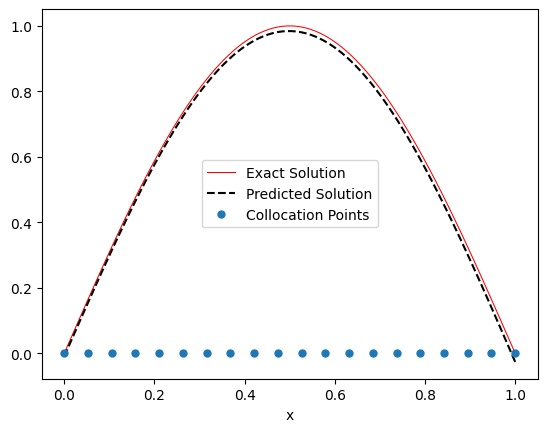

In [ ]:
plt.plot(x_test,u_true,label = "Exact Solution",linestyle="-",color = "red",linewidth = 0.75)
plt.plot(x_test,u_pred,label = "Predicted Solution",linestyle="--",linewidth = 1.5,color = "black")
plt.plot(x_train,np.zeros_like(x_train),label="Collocation Points",linestyle = "None", marker = "o",markersize  =5)
plt.xlabel("x")
plt.legend()
plt.show()

### Convergence Study

In [ ]:
 epochs = [1000,2000,4000,8000]
L2_err = []

# generate the training set
n_train = 20
x_train = torch.linspace(0,1,n_train).reshape(-1,1).to(device)

# generate the test set
n_test = 100
x_test = torch.linspace(0,1,n_test).reshape(-1,1).to(device)
u_true = u_exact(x_test)

for epoch in epochs:
    u = train_PINN(x_train,epoch,verbose=False)
    u_pred = u(x_test)

    L2_err.append(L2_error(u_pred,u_true).detach().cpu().numpy())

table = pd.DataFrame(data= np.transpose([epochs, L2_err]),columns=["Epochs","L2 error"])

,Epochs,L2 error
0,1000.0,0.020811
1,2000.0,0.002941
2,4000.0,0.006710
3,8000.0,0.000474


In [ ]:
train_size = [20,40,80,160]
L2_err = []
num_epochs = 5000

# generate the test set
n_test = 1000
x_test = torch.linspace(0,1,n_test).reshape(-1,1).to(device)
u_true = u_exact(x_test)

for n_train in train_size:
    # generate the training set
    x_train = torch.linspace(0,1,n_train).reshape(-1,1).to(device)

    u = train_PINN(x_train,num_epochs,verbose=False)
    u_pred = u(x_test)

    L2_err.append(L2_error(u_pred,u_true).detach().cpu().numpy())

table = pd.DataFrame(data= np.transpose([train_size, L2_err]),columns=["Train size","L2 error"])
table

,Train size,L2 error
0,20.0,4.751730e+13
1,40.0,1.306331e-01
2,80.0,3.932746e-02
3,160.0,6.403643e-02


### Convergence Study for $m=2$

In [ ]:
epochs = [1000,2000,4000,8000]
L2_err = []
m=2
# generate the training set
n_train = 20
x_train = torch.linspace(0,1,n_train).reshape(-1,1).to(device)

# generate the test set
n_test = 100
x_test = torch.linspace(0,1,n_test).reshape(-1,1).to(device)
u_true = u_exact(x_test,m)

for epoch in epochs:
    u = train_PINN(x_train=x_train,num_epochs=epoch,m=m,verbose=False)
    u_pred = u(x_test)

    L2_err.append(L2_error(u_pred,u_true).detach().cpu().numpy())

table = pd.DataFrame(data= np.transpose([epochs, L2_err]),columns=["Epochs","L2 error"])
table

In [ ]:
train_size =  [20,40,80,160]
L2_err = []
num_epochs = 5000
m=2

# generate the test set
n_test = 1000
x_test = torch.linspace(0,1,n_test).reshape(-1,1).to(device)
u_true = u_exact(x_test,m)

for n_train in train_size:
    # generate the training set
    x_train = torch.linspace(0,1,n_train).reshape(-1,1).to(device)

    u = train_PINN(x_train=x_train,num_epochs=num_epochs,m=m,verbose=False)
    u_pred = u(x_test)

    L2_err.append(L2_error(u_pred,u_true).detach().cpu().numpy())

table = pd.DataFrame(data= np.transpose([train_size, L2_err]),columns=["Train size","L2 error"])
table

In [ ]:
x_train.requires_grad_(False)
x_train = x_train.detach().cpu().numpy()
x_test = x_test.detach().cpu().numpy()
u_pred = u_pred.detach().cpu().numpy()
u_true = u_true.detach().cpu().numpy()

In [ ]:
plt.plot(x_test,u_true,label = "Exact Solution",linestyle="-",color = "red",linewidth = 1.75)
plt.plot(x_test,u_pred,label = "Predicted Solution",linestyle="--",linewidth = 2.5,color = "black")
plt.plot(x_train,np.zeros_like(x_train),label="Collocation Points",linestyle = "None", marker = "o",markersize  =5)
plt.xlabel("x")
plt.legend()
plt.show()

### Convergence Study for $m=4$

In [ ]:
epochs = [4000,8000,16000,32000]
L2_err = []
m=4
# generate the training set
n_train = 20
x_train = torch.linspace(0,1,n_train).reshape(-1,1).to(device)

# generate the test set
n_test = 100
x_test = torch.linspace(0,1,n_test).reshape(-1,1).to(device)
u_true = u_exact(x_test,m)

for epoch in epochs:
    u = train_PINN(x_train=x_train,num_epochs=epoch,m=m,verbose=False)
    u_pred = u(x_test)

    L2_err.append(L2_error(u_pred,u_true).detach().cpu().numpy())

table = pd.DataFrame(data= np.transpose([epochs, L2_err]),columns=["Epochs","L2 error"])
table

In [ ]:
train_size =  [20,40,80,160]
L2_err = []
num_epochs = 10000
m=4

# generate the test set
n_test = 1000
x_test = torch.linspace(0,1,n_test).reshape(-1,1).to(device)
u_true = u_exact(x_test,m)

for n_train in train_size:
    # generate the training set
    x_train = torch.linspace(0,1,n_train).reshape(-1,1).to(device)

    u = train_PINN(x_train=x_train,num_epochs=num_epochs,m=m,verbose=False)
    u_pred = u(x_test)

    L2_err.append(L2_error(u_pred,u_true).detach().cpu().numpy())

table = pd.DataFrame(data= np.transpose([train_size, L2_err]),columns=["Train size","L2 error"])
table

In [ ]:
x_train.requires_grad_(False)
x_train = x_train.detach().cpu().numpy()
x_test = x_test.detach().cpu().numpy()
u_pred = u_pred.detach().cpu().numpy()
u_true = u_true.detach().cpu().numpy()

In [ ]:
plt.plot(x_test,u_true,label = "Exact Solution",linestyle="-",color = "red",linewidth = 1.75)
plt.plot(x_test,u_pred,label = "Predicted Solution",linestyle="--",linewidth = 2.5,color = "black")
plt.plot(x_train,np.zeros_like(x_train),label="Collocation Points",linestyle = "None", marker = "o",markersize  =5)
plt.xlabel("x")
plt.legend()
plt.show()

Approximating highly oscillatory solutions using PINNs is challenging. As demonstrated above, an increase in the parameter $m$ correlates with an increased number of epochs required to achieve a desired accuracy. This difficulty can be mitigated by increasing either the number of collocation points or the number of hidden layers in the neural network.

## 2D Problem

Consider the following two-dimensional problem
$$
\begin{align*}
    -\Delta u +u &= (m^2\pi^2+n^2\pi^2+1)\sin(m\pi x)\sin(n\pi y),\hspace{10pt}\text{ in }(0,1)\\
    u(0)&=u(1)=0
\end{align*}
$$

The exact solution is given by $u_{mn} = \sin(m\pi x)\sin(n \pi y)$.

In [ ]:
# RHS
def f(x,m=1,n=1):
    return (m**2*pi**2+n**2*pi**2+1)*sin(m*pi*x[0])*sin(n*pi*x[1])

# Exact Solution
def u_exact(x,m=1,n=1):
    return sin(m*pi*x[0])*sin(n*pi*x[1])

### Creating PINN

In [ ]:
# building PINN neural network using nn.Module class
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 512),          # here 2 describes that we are working in 2D
            nn.Tanh(),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        return self.net(x)

# incorporating automatic differentiation
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs),create_graph=True,retain_graph=True)[0]

### Loss function

Here, since the boundary is 1D we sample ennough points on the boundary to impose the boundary conditions into the loss function. That is, $MSE_b$ takes the form
$$
\begin{align*}
    MSE_b =\frac{1}{N_b}\sum_{k=1}^{N_b} |u(x_k)|^2
\end{align*}
$$

and $MSE_i$ has the same form except that the points are in 2D.

In [ ]:
def compute_loss(model: nn.Module, x_train_i: torch.Tensor,x_train_b:torch.Tensor,m=1,n=1):
    # evaluating u(x), f(x), du/dx, d^2u/dx^2 at training data points
    x_train = torch.cat([x_train_i,x_train_b])
    x_train.requires_grad_(True)
    u = model(x_train)
    u.requires_grad_(True)
    du = grad(u,x_train)
    du.requires_grad_(True)

    du_dx = du[:, 0].view(-1, 1)                          # du/dx component
    du_dy = du[:, 1].view(-1, 1)                          # du/dy component

    # calculating second derivatives: d^2u/dx^2 and d^2u/dy^2
    d2u_dx2 = grad(du_dx, x_train)[:, 0].view(-1, 1)      # Take x component again
    d2u_dy2 = grad(du_dy, x_train)[:, 1].view(-1, 1)      # Take y component again

    # computin the second derivative by taking the gradient of du with respect to the corresponding component of x_train
    d2u_dx2 = grad(du[:, 0], x_train)[:, 0].view(-1, 1)
    d2u_dy2 = grad(du[:, 1], x_train)[:, 1].view(-1, 1)
    d2u = d2u_dx2 + d2u_dy2

    # calculating interior loss for problem
    residual_i = -d2u[:len(x_train_i),0]  + u[:len(x_train_i),0] - f(x_train_i.T,m,n)        # PDE-based interior residual
    interior_loss = torch.mean(residual_i**2)                                                # mean-squared interior loss

    # calculating boundary loss for problem
    residual_b = u[len(x_train_i):,0]
    boundary_loss = torch.mean(residual_b**2)                                                 # mean-squared boundary loss

    return interior_loss + boundary_loss

### Generating Training and test dataset

In [ ]:
# generating interior points on the square
def generate_collocation_points(N_i):
    xx = torch.linspace(0,1,N_i+2)[1:-1]
    yy = torch.linspace(0,1,N_i+2)[1:-1]
    x = []
    for i in range(len(xx)):
        for j in range(len(yy)):
            x.append([xx[i],yy[j]])
    return torch.tensor(x, dtype=torch.float32)

# generating boundary points
def generate_boundary_points(N_b):
    ref = torch.linspace(0,1,N_b+2)[1:-1]
    x = []
    for i in range(len(ref)):
        x.append([ref[i],0])
        x.append([ref[i],1])
        x.append([0,ref[i]])
        x.append([1,ref[i]])
    x.append([0,0])
    x.append([1,0])
    x.append([0,1])
    x.append([1,1])
    return torch.tensor(x, dtype=torch.float32)

The number of collocation points in the interior of square is $N_i^2$ and the number of boundary points are $4(N_b+1)$, where $N_i$ and $N_b$ are the inputs of `generate_collocation_points` and `generate_boundary_points` respectively.

In [ ]:
# interior points
N_i = 30
x_train_i = generate_collocation_points(N_i).to(device)
x_train_i.shape

In [ ]:
# boundary points
N_b = 14
x_train_b = generate_boundary_points(N_b).to(device)
x_train_b.shape

In [ ]:
# generating uniformly spaced points for test set on the closed square
def generate_test(N):
    xx = torch.linspace(0,1,N)
    yy = torch.linspace(0,1,N)
    x = []
    for i in range(len(xx)):
        for j in range(len(yy)):
            x.append([xx[i],yy[j]])
    return torch.tensor(x, dtype=torch.float32)

The test set consists of uniformly spaced points in $[0,1]$.

In [ ]:
N = 35
x_test = generate_test(N).to(device)
x_test.shape

In [ ]:
u_true = u_exact(x_test.T)
u_true.shape

### Training and predicting using PINN

Here, LBFGS optimizer with learning rate 0.001 is used to minimize the loss function described above. 5% of the train set is used for validating the output of training process.

In [ ]:
# defining a function to train PINN
def train_PINN(x_train_i,x_train_b,num_epochs,m=1,n=1,verbose = True, create_graph = True):
    model = PINN().to(device)
    optimizer = torch.optim.LBFGS(model.parameters(), lr=0.001)

    # initializing arrays for storing training and validation loss
    train_losses = []
    val_losses = []

    N_i_val = int(0.05*len(x_train_i))
    N_b_val = int(0.05*len(x_train_b))

    N_i_train = len(x_train_i) - N_i_val
    N_b_train = len(x_train_b) - N_b_val

    # splitting into training and validation
    x_training_i , x_validation_i = random_split(TensorDataset(x_train_i) , [N_i_train,N_i_val])
    x_training_b , x_validation_b = random_split(TensorDataset(x_train_b) , [N_b_train,N_b_val])

    x_training_i = x_training_i.dataset.tensors[0][x_training_i.indices].to(device)
    x_validation_i = x_validation_i.dataset.tensors[0][x_validation_i.indices].to(device)

    x_training_b = x_training_b.dataset.tensors[0][x_training_b.indices].to(device)
    x_validation_b = x_validation_b.dataset.tensors[0][x_validation_b.indices].to(device)


    # defining the closure function
    def closure():
        optimizer.zero_grad()
        loss = compute_loss(model, x_training_i, x_training_b, m, n)
        loss.backward()
        return loss

    for epoch in range(num_epochs):
        model.train()                                                         # Set model to training mode
        train_loss = optimizer.step(closure)

        model.eval()                                                          # Set model to evaluation mode
        val_loss = compute_loss(model, x_validation_i, x_validation_b, m, n)

        if epoch % 10 == 0:
            train_losses.append(train_loss.item())
            val_losses.append(val_loss.item())

        if epoch % 200 == 0 and verbose ==True:
            print(f"Full Training Epoch {epoch}, Training Loss: {train_loss.item():.6f}, Validation Loss: {val_loss.item():.6f}")

    # creating loss curves with epochs
    if create_graph == True:
        plt.plot(train_losses, label = "Training Loss")
        plt.plot(val_losses, label = "Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.xticks(ticks=range(0, len(train_losses) + 1, 100),labels = range(0, 10*len(train_losses) + 1, 1000))
        plt.title("Loss Curves")
        plt.legend()
        plt.grid(True)
        plt.show()
    return model

In [ ]:
num_epochs = 2000
u = train_PINN(x_train_i,x_train_b,num_epochs)

In [ ]:
# Predicting using obtained u
u_pred = u(x_test)[:,0].to(device)
u_pred.shape

In [ ]:
u_pred.shape == u_true.shape

### Calculating $L^2$ error of the solution

In [ ]:
def L2_error(u_pred,u_true):
    return torch.sum((u_true - u_pred)**2)

In [ ]:
error = L2_error(u_pred,u_true)
print(f"L2_error of approximation: {error}")

### Plotting the solution

In [ ]:
x_train_i.requires_grad_(False)
x_test = x_test.detach().cpu().numpy()
u_pred = u_pred.detach().cpu().numpy()
u_true = u_true.detach().cpu().numpy()

In [ ]:
# Reshape test data for surface plots
N = int(np.sqrt(x_test.shape[0]))
X = x_test[:, 0].reshape(N, N)
Y = x_test[:, 1].reshape(N, N)
u_pred = u_pred.reshape(N, N)
u_true = u_true.reshape(N, N)
x_train = np.vstack([x_train_i.detach().cpu().numpy(),x_train_b.detach().cpu().numpy()])

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

# Surface: Exact solution
ax.plot_surface(X, Y, u_true, alpha = 0.7, cmap="Blues", label='Exact')

# Surface: Predicted solution (wireframe or different alpha)
ax.plot_surface(X, Y, u_pred, alpha = 0.8, cmap="Reds", label="Predicted")

# Scatter: Collocation points at z=0
ax.scatter(x_train[:, 0], x_train[:, 1], np.zeros_like(x_train[:, 0]),
           color='black', s=8, marker='o', label='Collocation Points')

# Labels and legend
ax.set_title("Exact vs Predicted Solution with Collocation Points")
ax.set_xlabel("x")
ax.set_ylabel("y")

plt.legend()
plt.show()

In [ ]:
# Reshape data (assuming square grid)
N = int(np.sqrt(x_test.shape[0]))
X = x_test[:, 0].reshape(N, N)
Y = x_test[:, 1].reshape(N, N)
u_pred = u_pred.reshape(N, N)
u_true = u_true.reshape(N, N)
x_train = np.vstack([x_train_i.detach().cpu().numpy(),x_train_b.detach().cpu().numpy()])

fig = go.Figure()

# Predicted surface
fig.add_trace(go.Surface(z=u_pred, x=X, y=Y, colorscale='Blues', opacity=1, name='Predicted',showlegend=True,showscale=False))

# Exact surface overlay
fig.add_trace(go.Surface(z=u_true, x=X, y=Y, colorscale='Reds', opacity=0.5, name='Exact',showlegend=True,showscale=False))

# Collocation points
fig.add_trace(go.Scatter3d(
    x=x_train[:, 0], y=x_train[:, 1], z=np.zeros_like(x_train[:, 0]),
    mode='markers', marker=dict(size=3, color='black'),
    name='Collocation Points',
    showlegend=True
))

fig.update_layout(
    title="PINN: Predicted vs Exact Solution",
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='u(x,y)'),
    width=900, height=700
)
fig.show()


### Convergence Study

In [ ]:
epochs = [1000,2000,4000,8000]
L2_err = []

# interior points
N_i = 30
x_train_i = generate_collocation_points(N_i).to(device)

# boundary points
N_b = 14
x_train_b = generate_boundary_points(N_b).to(device)

# generate the test set
N = 35
x_test = generate_test(N).to(device)
u_true = u_exact(x_test)

for epoch in epochs:
    u = train_PINN(x_train_i,x_train_b,epoch,verbose=False,create_graph=False)
    u_pred = u(x_test)

    L2_err.append(L2_error(u_pred,u_true).detach().cpu().numpy())

table = pd.DataFrame(data= np.transpose([epochs, L2_err]),columns=["Epochs","L2 error"])
table

In [ ]:
N_i = [10,20,40,80]
L2_err = []
num_epochs = 5000

# boundary points
N_b = 14
x_train_b = generate_boundary_points(N_b).to(device)

# generate the test set
N = 100
x_test = generate_test(N).to(device)
u_true = u_exact(x_test)

for n_train in N_i:
    # generate the training set
    x_train_i = generate_collocation_points(n_train).to(device)

    u = train_PINN(x_train_i,x_train_b,num_epochs,verbose=False,create_graph=False)
    u_pred = u(x_test)

    L2_err.append(L2_error(u_pred,u_true).detach().cpu().numpy())

table = pd.DataFrame(data= np.transpose([train_size, L2_err]),columns=["Train size","L2 error"])
table

In [ ]:
N_b = [8,16,32]
L2_err = []
num_epochs = 5000

# boundary points
N_i = 30
x_train_b = generate_collocation_points(N_i).to(device)

# generate the test set
N = 100
x_test = generate_test(N).to(device)
u_true = u_exact(x_test)

for n_train in N_b:
    # generate the training set
    x_train_i = generate_boundary_points(n_train).to(device)

    u = train_PINN(x_train_i,x_train_b,num_epochs,verbose=False,create_graph=False)
    u_pred = u(x_test)

    L2_err.append(L2_error(u_pred,u_true).detach().cpu().numpy())

table = pd.DataFrame(data= np.transpose([train_size, L2_err]),columns=["Train size","L2 error"])
table

### Convergence Study for $m=2$ and $n=2$

In [ ]:
epochs = [2000,4000,8000,16000]
L2_err = []
m=2
n=2

# interior points
N_i = 30
x_train_i = generate_collocation_points(N_i).to(device)

# boundary points
N_b = 14
x_train_b = generate_boundary_points(N_b).to(device)

# generate the test set
N = 35
x_test = generate_test(N).to(device)
u_true = u_exact(x_test)

for epoch in epochs:
    u = train_PINN(x_train_i,x_train_b,epoch,m,n,verbose=False,create_graph=False)
    u_pred = u(x_test)

    L2_err.append(L2_error(u_pred,u_true).detach().cpu().numpy())

table = pd.DataFrame(data= np.transpose([epochs, L2_err]),columns=["Epochs","L2 error"])
table

In [ ]:
N_i = [10,20,40,80]
L2_err = []
num_epochs = 5000

# boundary points
N_b = 14
x_train_b = generate_boundary_points(N_b).to(device)

# generate the test set
N = 100
x_test = generate_test(N).to(device)
u_true = u_exact(x_test)

for n_train in N_i:
    # generate the training set
    x_train_i = generate_collocation_points(n_train).to(device)

    u = train_PINN(x_train_i,x_train_b,num_epochs,m,n,verbose=False,create_graph=False)
    u_pred = u(x_test)

    L2_err.append(L2_error(u_pred,u_true).detach().cpu().numpy())

table = pd.DataFrame(data= np.transpose([train_size, L2_err]),columns=["Train size","L2 error"])
table

In [ ]:
N_b = [8,16,32]
L2_err = []
num_epochs = 5000

# boundary points
N_i = 30
x_train_b = generate_collocation_points(N_i).to(device)

# generate the test set
N = 100
x_test = generate_test(N).to(device)
u_true = u_exact(x_test)

for n_train in N_b:
    # generate the training set
    x_train_i = generate_boundary_points(n_train).to(device)

    u = train_PINN(x_train_i,x_train_b,num_epochs,m,n,verbose=False,create_graph=False)
    u_pred = u(x_test)

    L2_err.append(L2_error(u_pred,u_true).detach().cpu().numpy())

table = pd.DataFrame(data= np.transpose([train_size, L2_err]),columns=["Train size","L2 error"])
table